In [4]:
import os

import matplotlib.pyplot as plt
import numpy as np

In [114]:
RNG_SEED = 42

plt.style.use('seaborn')
plt.rcParams.update({'font.size': 22})
np.random.seed(seed=RNG_SEED)


def set_size(width_pt, fraction=1, subplots=(1, 1)):
    """Source: https://jwalton.info/Matplotlib-latex-PGF/"""
    fig_width_pt = width_pt * fraction
    inches_per_pt = 1 / 72.27
    golden_ratio = (5**.5 - 1) / 2
    fig_width_in = fig_width_pt * inches_per_pt
    fig_height_in = fig_width_in * golden_ratio * (subplots[0] / subplots[1])
    return (fig_width_in, fig_height_in)

In [115]:
class ToyDataset:
    def __init__(self, size):
        self.size = size
        mask = np.random.binomial(1, 0.8, size=(size // 2,))[:, None]
        g1 = np.random.randn(size // 2, 2) + 5
        g2 = np.random.randn(size // 2, 2) - 5
        self.ds = np.float32(g1 * mask + g2 * (1 - mask))
        self.ds_y = mask
        
        self.ds_min = self.ds.min()
        self.ds_max = self.ds.max()
        

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        return self.ds[idx], self.ds_y[idx]

In [116]:
ds = ToyDataset(5000)

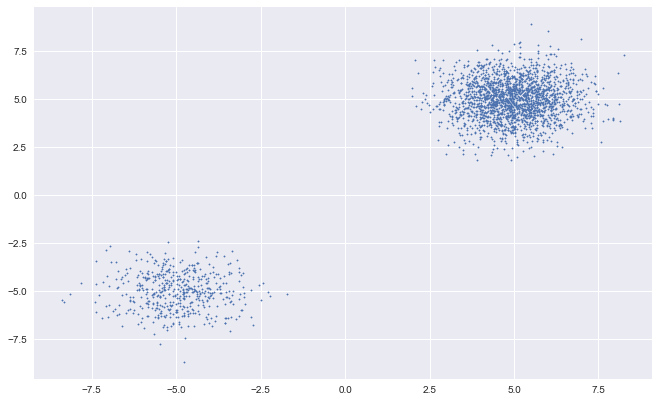

In [117]:
width, height = set_size(800)
fig, ax = plt.subplots(1, 1, figsize=(width, height))
ax.scatter(ds.ds[:, 0], ds.ds[:, 1], s=2)

In [139]:
def make_spirals(n_samples, noise_std=0., rotations=1.):
    ts = np.linspace(0, 1, n_samples)
    rs = ts ** 0.5
    thetas = rs * rotations * 2 * np.pi
    signs = np.random.randint(0, 2, (n_samples,)) * 2 - 1
    labels = (signs > 0).astype(int)

    xs = rs * signs * np.cos(thetas) + np.random.randn(n_samples) * noise_std
    ys = rs * signs * np.sin(thetas) + np.random.randn(n_samples) * noise_std
    points = np.stack([xs, ys], axis=1)
    return points, labels

points, labels = make_spirals(5000, noise_std=0.05, rotations=1.5)

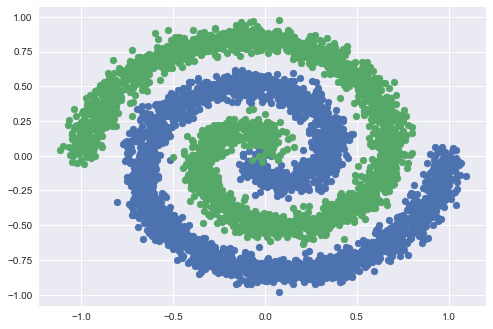

In [140]:
plt.scatter(points[np.where(labels == 0), 0], points[np.where(labels == 0), 1])
plt.scatter(points[np.where(labels == 1), 0], points[np.where(labels == 1), 1])

In [142]:
class ToyDataset:
    def __init__(self):
        self.size = 5_000
        rotations = 1.5
        noise_std = 0.05

        self.x, self.y = self._make_spirals(self.size, noise_std, rotations)

        self.ds_min = self.x.min()
        self.ds_max = self.x.max()

    def __len__(self):
        return self.size

    def _make_spirals(self, n_samples, noise_std=0.0, rotations=1.0):
        ts = np.linspace(0, 1, n_samples)
        rs = ts**0.5
        thetas = rs * rotations * 2 * np.pi
        signs = np.random.randint(0, 2, (n_samples,)) * 2 - 1
        labels = (signs > 0).astype(int)

        xs = rs * signs * np.cos(thetas) + np.random.randn(n_samples) * noise_std
        ys = rs * signs * np.sin(thetas) + np.random.randn(n_samples) * noise_std
        points = np.stack([xs, ys], axis=1)
        return points, labels

    def _normalize(self, pt):
        return (pt - self.ds_min) / (self.ds_max - self.ds_min)

    def __getitem__(self, idx):
        return {'x': self._normalize(self.x[idx]), 'y': self.y[idx]}

In [143]:
ds = ToyDataset()

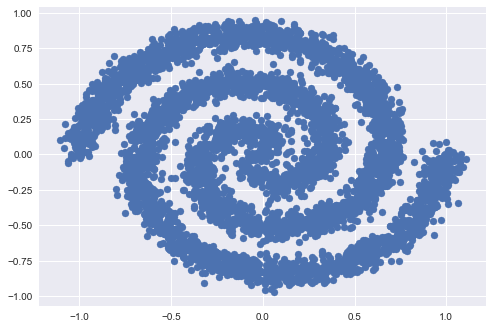

In [145]:
plt.scatter(ds.x[:, 0], ds.x[:, 1])

In [146]:
ds.y

array([0, 1, 0, ..., 0, 1, 1])

In [167]:
cd ../

/Users/gautam/Desktop/workbench/dojo


## MNIST Inference

In [168]:
import mnist.train as mnist

/Users/gautam/miniconda3/envs/dojo/lib/python3.9/site-packages/jax/_src/lib/__init__.py:34: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


In [186]:
import pathlib
import jax
import jax.numpy as jnp
from flax.training import checkpoints

class Config:
    learning_rate = 1e-3
    beta1 = 0.9
    beta2 = 0.999
    
config = Config
rng = jax.random.PRNGKey(0)

workdir = '/tmp/mnist12'
ckpt_dir = pathlib.Path(workdir) / 'checkpoints'
rng, init_rng = jax.random.split(rng)
state = mnist.create_train_state(init_rng, config)
state = checkpoints.restore_checkpoint(ckpt_dir, state)

train_dataset = torchvision.datasets.MNIST('/tmp/mnist', train=True, download=True)
im_labels = [(im, label) for im, label in train_dataset]
images, labels = zip(*im_labels)
images = jnp.array([np.array(im)[:, :, None] / 255.0 for im in images])
labels = jnp.array(labels)

In [188]:
logits = state.apply_fn({'params': state.params}, images)

In [189]:
logits.shape

(60000, 10)

In [194]:
import optax
from jax import nn

In [196]:
losses = optax.softmax_cross_entropy(logits=logits, labels=nn.one_hot(labels, num_classes=10))

In [206]:
loss = np.array(losses)
highloss = sorted(enumerate(loss), key=lambda x: x[1], reverse=True)

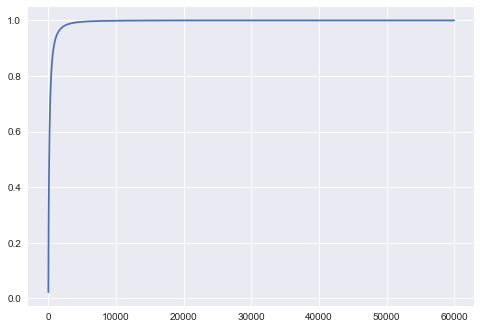

In [210]:
accumulation = np.cumsum(sorted(loss, reverse=True)) / np.sum(loss)
plt.plot(accumulation)

In [242]:
pred_labels = logits.argmax(-1)
accumulation[263]

0.7032602

In [219]:
highloss_idx, highloss_val = zip(*highloss)

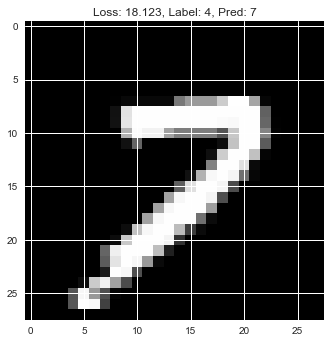

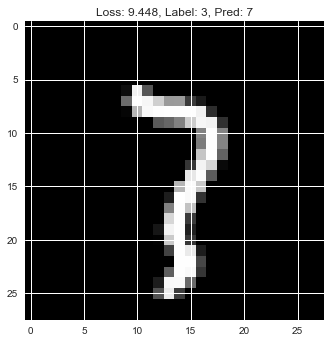

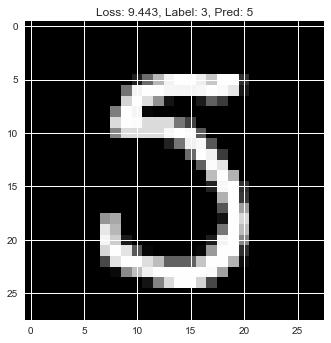

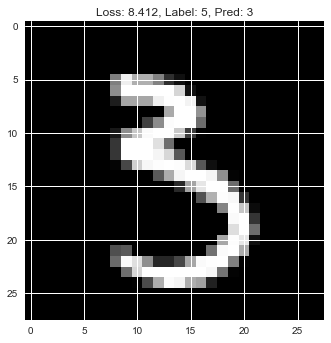

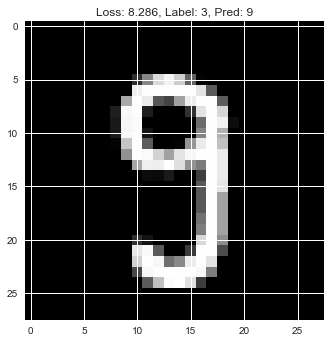

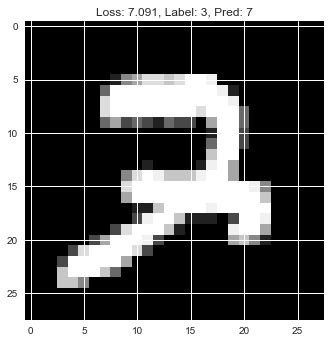

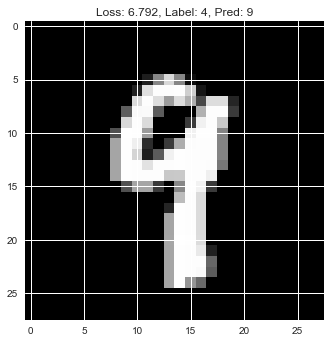

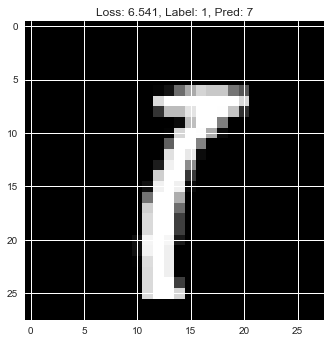

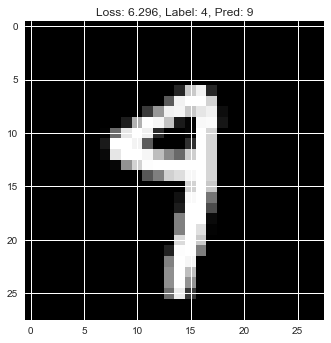

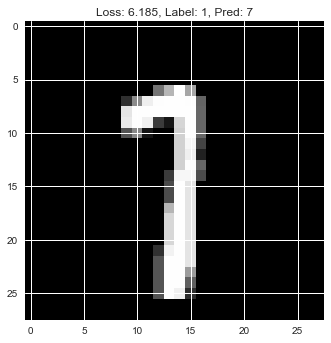

In [243]:
for i, idx in enumerate(highloss_idx[:10]):
    plt.imshow(1 - images[idx])
    plt.title(f'Loss: {highloss_val[i]:.3f}, Label: {labels[idx]}, Pred: {pred_labels[idx]}')
    plt.show()

In [323]:
from jax import vjp

def vgrad(f, x):
    y, vjp_fn = vjp(f, x)
    return vjp_fn(jnp.ones(y.shape))[0]

def normalize(x):
    return (x - x.min()) / (x.max() - x.min())

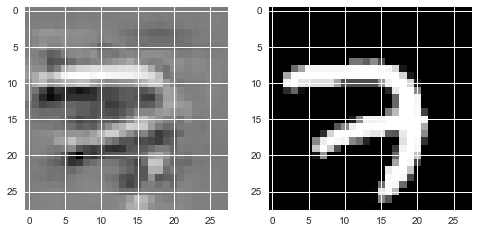

In [324]:
idx = 5000

z = lambda x: state.apply_fn({'params': state.params}, x)
attn = vgrad(z, images[idx][None])

fig, axes = plt.subplots(1, 2)
axes[0].imshow(normalize(attn[0]))
axes[1].imshow(1-images[idx])

## CoordConv

In [385]:
import scipy.signal
import flax.linen as nn
from jax import lax
import functools

In [403]:
onehots = np.pad(
            np.eye(3136).reshape((3136, 56, 56, 1)),
            ((0, 0), (4, 4), (4, 4), (0, 0)),
            "constant",
        )

conv2d = jax.vmap(functools.partial(jax.scipy.signal.convolve2d, mode='same'), in_axes=(0, None))
images = np.array(conv2d(onehots[:, :, :, 0], np.ones((9, 9))))

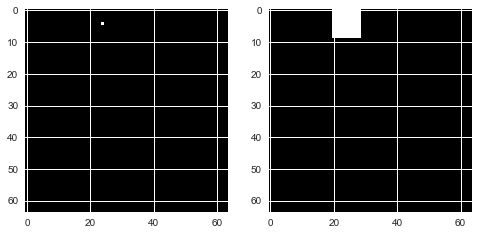

In [405]:
idx = 20
fig, axes = plt.subplots(1, 2)
axes[0].imshow(1 - onehots[idx])
axes[1].imshow(1 - images[idx])

In [411]:
np.where(onehots[1] == 1)

(array([4]), array([5]), array([0]))

In [1]:
### other stuff


In [13]:
class CharDataset:
    def __init__(self, data, block_size):
        chars = sorted(list(set(data)))
        data_size, vocab_size = len(data), len(chars)
        print('data has %d characters, %d unique.' % (data_size, vocab_size))

        self.stoi = {ch: i for i, ch in enumerate(chars)}
        self.itos = {i: ch for i, ch in enumerate(chars)}
        self.block_size = block_size
        self.vocab_size = vocab_size
        self.data = data

    def __len__(self):
        return len(self.data) - self.block_size

    def __getitem__(self, idx):
        # grab a chunk of (block_size + 1) characters from the data
        chunk = self.data[idx : idx + self.block_size + 1]
        # encode every character to an integer
        dix = [self.stoi[s] for s in chunk]
        x = np.array(dix[:-1], dtype=np.int64)
        y = np.array(dix[1:], dtype=np.int64)
        return x, y

In [14]:
import requests
r = requests.get('https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt')

In [15]:
dataset = CharDataset(r.text, 128)

data has 1115394 characters, 65 unique.


In [28]:
idx = 10
x, y = dataset[idx]
print(''.join([dataset.itos[i] for i in x]))

print('\n====== NEXT =====\n')
print(''.join([dataset.itos[i] for i in y]))

zen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than t

====== NEXT =====

en:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to


In [30]:
dataset.block_size

128

In [34]:
import softraxterizer as sf

In [36]:
dir(sf)

['__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'eps',
 'get_pixel',
 'jax',
 'np',
 'softras']

In [97]:
canvas, shape = sf.get_pixel()

In [118]:
import jax.numpy as jnp
mesh = jnp.array([[[0, 0, 0], [1, 0, 0], [0, 1, 0]]])
C = jnp.array([[1, 1, 1]])

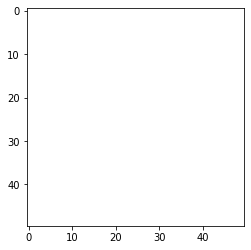

In [119]:
image = sf.softras(mesh, canvas, C)#, 1e-2, 1e-2)

plt.imshow(image.reshape(*shape))

### VGG16 in JAX

In [129]:
from torchvision.models import vgg16

In [131]:
model = vgg16(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /Users/gautam/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 528M/528M [00:26<00:00, 21.0MB/s]


In [142]:
model.features[3].state_dict()

OrderedDict()

In [143]:
model.features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [333]:
import flax.linen as nn
from functools import partial

class VGG16(nn.Module):
    def setup(self):
        self.backbone = nn.Sequential([
            nn.Conv(64, kernel_size=(3, 3), strides=(1, 1), padding=(1, 1)),
            nn.relu,
            nn.Conv(64, kernel_size=(3, 3), strides=(1, 1), padding=(1, 1)),
            nn.relu,
            partial(nn.max_pool, window_shape=(2, 2), strides=(2, 2), padding=((0, 0), (0, 0))),
            nn.Conv(128, kernel_size=(3, 3), strides=(1, 1), padding=(1, 1)),
            nn.relu,
            nn.Conv(128, kernel_size=(3, 3), strides=(1, 1), padding=(1, 1)),
            nn.relu,
            partial(nn.max_pool, window_shape=(2, 2), strides=(2, 2), padding=((0, 0), (0, 0))),
            nn.Conv(256, kernel_size=(3, 3), strides=(1, 1), padding=(1, 1)),
            nn.relu,
            nn.Conv(256, kernel_size=(3, 3), strides=(1, 1), padding=(1, 1)),
            nn.relu,
            nn.Conv(256, kernel_size=(3, 3), strides=(1, 1), padding=(1, 1)),
            nn.relu,
            partial(nn.max_pool, window_shape=(2, 2), strides=(2, 2), padding=((0, 0), (0, 0))),
            nn.Conv(512, kernel_size=(3, 3), strides=(1, 1), padding=(1, 1)),
            nn.relu,
            nn.Conv(512, kernel_size=(3, 3), strides=(1, 1), padding=(1, 1)),
            nn.relu,
            nn.Conv(512, kernel_size=(3, 3), strides=(1, 1), padding=(1, 1)),
            nn.relu,
            partial(nn.max_pool, window_shape=(2, 2), strides=(2, 2), padding=((0, 0), (0, 0))),
            nn.Conv(512, kernel_size=(3, 3), strides=(1, 1), padding=(1, 1)),
            nn.relu,
            nn.Conv(512, kernel_size=(3, 3), strides=(1, 1), padding=(1, 1)),
            nn.relu,
            nn.Conv(512, kernel_size=(3, 3), strides=(1, 1), padding=(1, 1)),
            nn.relu,
            partial(nn.max_pool, window_shape=(2, 2), strides=(2, 2), padding=((0, 0), (0, 0))),            
        ])
        
    def __call__(self, x):
        return self.backbone(x)

In [334]:
import jax

mdl = Net()
rng = jax.random.PRNGKey(0)
params = mdl.init(rng, jnp.ones([1, 32, 32, 3]))['params']
params['backbone']['layers_2']['kernel'].shape

(3, 3, 64, 64)

In [335]:
# flax conv kernel is (k, k, in_c, out_c)
# pytorch conv kernel is (out_c, in_c, k, k)

In [336]:
model.features[0].state_dict()['weight'].permute((2, 3, 1, 0)).shape

torch.Size([3, 3, 3, 64])

In [337]:
mdl.apply({'params': params}, jnp.ones((1, 32, 32, 3))).shape

(1, 1, 1, 512)

In [359]:
from flax.core.frozen_dict import freeze, unfreeze

torch_params = model.features.state_dict()
mutable_params = unfreeze(params)
for param_name in mutable_params['backbone'].keys():
    layer_id = param_name.split('_')[-1]

    torch_kernel = torch_params[f'{layer_id}.weight'].permute((2, 3, 1, 0))
    torch_bias = torch_params[f'{layer_id}.bias']
    
    mutable_params['backbone'][param_name]['kernel'] = jnp.array(torch_kernel)
    mutable_params['backbone'][param_name]['bias'] = jnp.array(torch_bias)

new_params = freeze(mutable_params)

jax_out = np.array(mdl.apply({'params': new_params}, jnp.ones((1, 64, 64, 3))))

In [349]:
import torch
torch_out = model.features(torch.ones((1, 3, 32, 32))).permute((0, 2, 3, 1)).detach().numpy()

In [358]:
np.allclose(torch_out, jax_out, 1e-3)

True

In [352]:
mdl.params

AttributeError: "Net" object has no attribute "params"

In [386]:
def load_image(path, height, width):
    """Load and resize image."""
    img = Image.open(path)
    img = img.resize((height, width), Image.BILINEAR)
    img = np.array(img).astype(np.float32)
    # img = img[:, :, ::-1]
    img = img / 255.0
    return img


In [375]:
cd dojo

[Errno 2] No such file or directory: 'dojo'
/Users/gautam/Desktop/workbench/dojo


In [376]:
from PIL import Image
z = load_image('style_transfer/abbey_road.jpg', 256, 256)

/var/folders/yc/sg2v7pxx3lx5qvhgy7szdch40000gn/T/ipykernel_7437/3267529619.py:4: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  img = img.resize((height, width), Image.BILINEAR)


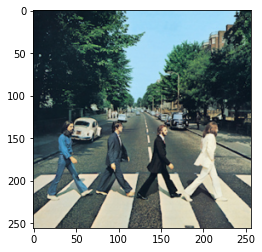

In [377]:
plt.imshow(z)

### Vector quantization

/var/folders/yc/sg2v7pxx3lx5qvhgy7szdch40000gn/T/ipykernel_7437/3267529619.py:4: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  img = img.resize((height, width), Image.BILINEAR)


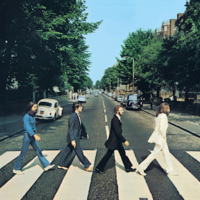

In [550]:
from PIL import Image
img = np.uint8(load_image('style_transfer/abbey_road.jpg', 200, 200) * 255)
Image.fromarray(img)

In [604]:
k = 2 ** 14

X = img.reshape(-1, 3)
means = X[np.random.choice(len(X), replace=False, size=(k,))]

for _ in range(20):
    buckets = {i: [] for i in range(k)}
    for pt in X:
        assignment = np.argmin(np.linalg.norm(pt - means, axis=-1))
        buckets[assignment].append(pt) 
    for i in range(k):
        if buckets[i]:
            means[i] = np.mean(buckets[i], axis=0).astype(np.uint8)

In [605]:
means

array([[ 69,  89,  85],
       [ 10,  20,  29],
       [ 25,  41,  46],
       ...,
       [ 69,  89,  85],
       [175, 217, 235],
       [ 25,  41,  46]], dtype=uint8)

In [606]:
img = np.uint8(load_image('style_transfer/abbey_road.jpg', 200, 200) * 255)

for x in range(200):
    for y in range(200):
        v = img[x, y]
        assignment = np.argmin(np.linalg.norm(v - means, axis=-1))
        img[x, y] = means[assignment]

/var/folders/yc/sg2v7pxx3lx5qvhgy7szdch40000gn/T/ipykernel_7437/3267529619.py:4: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  img = img.resize((height, width), Image.BILINEAR)


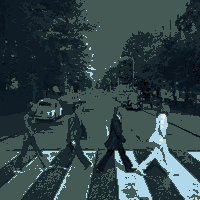

In [607]:
Image.fromarray(img)

array([19317, 21513, 35434, ..., 31956, 12907, 38790])

In [661]:
class BinaryOpDataset:
    def __init__(self, p, is_train, train_frac):
        self.p = p
        self.binary_op = lambda a, b: a + b
        self.is_train = is_train
        self.train_frac = train_frac
        
        self.offset = 0 if is_train else int(train_frac * p * p)
        
        vocab = ['o', '='] + list(range(p))
        self.stoi = {ch: i for i, ch in enumerate(vocab)}
        self.itos = {i: ch for i, ch in enumerate(vocab)}

    def __len__(self):
        if self.is_train:
            return int(self.train_frac * self.p * self.p)
        return self.p * self.p - self.offset

    def __getitem__(self, idx):
        # a o b = binary_op(a, b) (mod p)
        idx += self.offset
        a = idx % self.p
        b = idx // self.p
        assert 0 <= a < self.p and 0 <= b < self.p
        c = self.binary_op(a, b) % self.p
        eq = [a, 'o', b, '=', c]
        encoded_eq = [self.stoi[ch] for ch in eq]

        x = np.array(encoded_eq[:-1], dtype=np.int64)
        y = np.array(encoded_eq[1:], dtype=np.int64)
        return {'x': x, 'y': y}

In [674]:
train_ds = BinaryOpDataset(97, True, 0.1)
val_ds = BinaryOpDataset(97, False, 0.1)
total_ds = BinaryOpDataset(5, True, 1)

def decode(x):
    return [train_ds.itos[i] for i in x]

In [675]:
for idx in range(len(train_ds)):
    print({'x': decode(train_ds[idx]['x']), 'y': decode(train_ds[idx]['y'])})
    
print("val")
for idx in range(len(val_ds)):
    print({'x': decode(val_ds[idx]['x']), 'y': decode(val_ds[idx]['y'])})
    
print("all")
for idx in range(len(total_ds)):
    print({'x': decode(total_ds[idx]['x']), 'y': decode(total_ds[idx]['y'])})

{'x': [0, 'o', 0, '='], 'y': ['o', 0, '=', 0]}
{'x': [1, 'o', 0, '='], 'y': ['o', 0, '=', 1]}
val
{'x': [2, 'o', 0, '='], 'y': ['o', 0, '=', 2]}
{'x': [3, 'o', 0, '='], 'y': ['o', 0, '=', 3]}
{'x': [4, 'o', 0, '='], 'y': ['o', 0, '=', 4]}
{'x': [0, 'o', 1, '='], 'y': ['o', 1, '=', 1]}
{'x': [1, 'o', 1, '='], 'y': ['o', 1, '=', 2]}
{'x': [2, 'o', 1, '='], 'y': ['o', 1, '=', 3]}
{'x': [3, 'o', 1, '='], 'y': ['o', 1, '=', 4]}
{'x': [4, 'o', 1, '='], 'y': ['o', 1, '=', 0]}
{'x': [0, 'o', 2, '='], 'y': ['o', 2, '=', 2]}
{'x': [1, 'o', 2, '='], 'y': ['o', 2, '=', 3]}
{'x': [2, 'o', 2, '='], 'y': ['o', 2, '=', 4]}
{'x': [3, 'o', 2, '='], 'y': ['o', 2, '=', 0]}
{'x': [4, 'o', 2, '='], 'y': ['o', 2, '=', 1]}
{'x': [0, 'o', 3, '='], 'y': ['o', 3, '=', 3]}
{'x': [1, 'o', 3, '='], 'y': ['o', 3, '=', 4]}
{'x': [2, 'o', 3, '='], 'y': ['o', 3, '=', 0]}
{'x': [3, 'o', 3, '='], 'y': ['o', 3, '=', 1]}
{'x': [4, 'o', 3, '='], 'y': ['o', 3, '=', 2]}
{'x': [0, 'o', 4, '='], 'y': ['o', 4, '=', 4]}
{'x': [1,

In [663]:
len(ds)

102

In [664]:
idx = 0
{'x': decode(ds[idx]['x']), 'y': decode(ds[idx]['y'])}

{'x': [2, 'o', 5, '='], 'y': ['o', 5, '=', 7]}

In [680]:
from multiprocessing import Pool
import numpy as np
import psutil
import scipy.signal
import time

num_cpus = psutil.cpu_count(logical=False)

def f(args):
    image, random_filter = args
    # Do some image processing.
    return scipy.signal.convolve2d(image, random_filter)[::5, ::5]

pool = Pool(num_cpus)

filters = [np.random.normal(size=(4, 4)) for _ in range(num_cpus)]

# Time the code below.
start = time.time()
for _ in range(10):
    image = np.zeros((100, 100))
    pool.map(f, zip(num_cpus * [image], filters))
dt = time.time() - start
print(dt)

Process SpawnPoolWorker-63:
Traceback (most recent call last):
  File "/Users/gautam/miniconda3/envs/dojo/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/gautam/miniconda3/envs/dojo/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/gautam/miniconda3/envs/dojo/lib/python3.9/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/Users/gautam/miniconda3/envs/dojo/lib/python3.9/multiprocessing/queues.py", line 368, in get
    return _ForkingPickler.loads(res)
AttributeError: Can't get attribute 'f' on <module '__main__' (built-in)>
Process SpawnPoolWorker-64:
Traceback (most recent call last):
  File "/Users/gautam/miniconda3/envs/dojo/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/gautam/miniconda3/envs/dojo/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._

KeyboardInterrupt: 

/multiprocessing/queues.py", line 366, in get
    res = self._reader.recv_bytes()
  File "/Users/gautam/miniconda3/envs/dojo/lib/python3.9/multiprocessing/connection.py", line 221, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/Users/gautam/miniconda3/envs/dojo/lib/python3.9/multiprocessing/connection.py", line 419, in _recv_bytes
    buf = self._recv(4)
  File "/Users/gautam/miniconda3/envs/dojo/lib/python3.9/multiprocessing/connection.py", line 384, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt
Traceback (most recent call last):
  File "/Users/gautam/miniconda3/envs/dojo/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/gautam/miniconda3/envs/dojo/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/gautam/miniconda3/envs/dojo/lib/python3.9/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/Users/gautam/miniconda3/envs/

In [677]:
num_cpus

8

In [681]:
import jax

In [720]:
block_size = 8
prompt = jnp.array([[1, 4, 5],
                   [1, 9, 2]])
prompt_len = block_size

a = jnp.array([1, 4, 5, 1, 5])
def f(i, carry):
    val = a[i]
    return carry * val

jax.lax.fori_loop(0, len(a), f, 1)

DeviceArray(100, dtype=int32)

In [739]:
seqs = jnp.pad(prompt, ((0, 0), (0, block_size - 3)))
def update(i, carry):
    next_token = a[i] * carry[:, 1]
    return carry.at[:, i].set(next_token)

jax.lax.fori_loop(0, block_size, update, seqs)

DeviceArray([[  4,  16,  80,  16,  80,  80,  80,  80],
             [  9,  36, 180,  36, 180, 180, 180, 180]], dtype=int32)

In [5]:
import jax
import jax.numpy as jnp
from jax import nn

In [101]:
logits = jnp.array([[1.5, 1.1, 2, 1, 3], [1.05, 2, 0, 1.5, 1.2]])
k = 3
topk_idx = jnp.argsort(-logits, axis=-1)[:, :k]

In [102]:
rows, _ = jnp.indices((1, k))
k_vals = jnp.min(logits[rows, topk_idx], axis=-1)


In [161]:
def top_p_logits(logits, p):
    """Nucleus sampling"""
    B, C = logits.shape
    sorted_idx = jnp.argsort(-logits, axis=-1)
    rows, _ = jnp.indices((B, C))
    sorted_logits = logits[rows, sorted_idx]
    cdf = jnp.cumsum(nn.softmax(sorted_logits, axis=-1), axis=-1)
    cutoff_idx = jnp.sum(cdf <= p, axis=-1)
    cutoff_vals = jnp.min(sorted_logits[rows, cutoff_idx[:, None]], axis=-1)
    return jnp.where(logits < cutoff_vals[:, None], float('-inf'), logits)

top_p_logits(logits, 0.93)

DeviceArray([[1.5 , 1.1 , 2.  , 1.  , 3.  ],
             [1.05, 2.  , -inf, 1.5 , 1.2 ]], dtype=float32)

In [162]:
import distrax

In [166]:
key = jax.random.PRNGKey(1234)
mu = jnp.array([[-1., 0., 1.]])

dist_distrax = distrax.Categorical
samples = dist_distrax.sample(seed=key)

samples

DeviceArray([[-1.0019782 , -0.01461947,  0.6765263 ]], dtype=float32)

In [187]:
dist = distrax.Categorical(probs=jnp.array([[0.9, 0.1], [0.1, 0.9]]))

In [285]:
prompt = jnp.array([[1, 2, 3, 4, 5]])
_, prompt_len = prompt.shape
steps = 20
block_size = 16


prompt = jnp.pad(prompt, ((0, 0), (0, steps)))


for i in range(prompt_len, prompt_len+steps):
    diff = jnp.where(i < block_size, 0, i - block_size)
    tokens = prompt[:, diff:block_size+diff]
    print(tokens)
    
    logits = jnp.arange(block_size)[None, :]
    next_token = 42 * logits[:, i - 1 if i < block_size else -1]
    prompt = prompt.at[:, i].set(next_token)
    
    # print(prompt)

[[1 2 3 4 5 0 0 0 0 0 0 0 0 0 0 0]]
[[  1   2   3   4   5 168   0   0   0   0   0   0   0   0   0   0]]
[[  1   2   3   4   5 168 210   0   0   0   0   0   0   0   0   0]]
[[  1   2   3   4   5 168 210 252   0   0   0   0   0   0   0   0]]
[[  1   2   3   4   5 168 210 252 294   0   0   0   0   0   0   0]]
[[  1   2   3   4   5 168 210 252 294 336   0   0   0   0   0   0]]
[[  1   2   3   4   5 168 210 252 294 336 378   0   0   0   0   0]]
[[  1   2   3   4   5 168 210 252 294 336 378 420   0   0   0   0]]
[[  1   2   3   4   5 168 210 252 294 336 378 420 462   0   0   0]]
[[  1   2   3   4   5 168 210 252 294 336 378 420 462 504   0   0]]
[[  1   2   3   4   5 168 210 252 294 336 378 420 462 504 546   0]]
[[  1   2   3   4   5 168 210 252 294 336 378 420 462 504 546 588]]
[[  2   3   4   5 168 210 252 294 336 378 420 462 504 546 588 630]]
[[  3   4   5 168 210 252 294 336 378 420 462 504 546 588 630 630]]
[[  4   5 168 210 252 294 336 378 420 462 504 546 588 630 630 630]]
[[  5 168 21

In [298]:
prompt = jnp.array([[1, 2, 3, 4, 5], [9, 10, 11, 12, 13]])
jax.lax.dynamic_slice(prompt, (0, 1), (prompt.shape[0], 4))

DeviceArray([[ 2,  3,  4,  5],
             [10, 11, 12, 13]], dtype=int32)

In [291]:
prompt

DeviceArray([[  1,   2,   3,   4,   5, 168, 210, 252, 294, 336, 378, 420,
              462, 504, 546, 588, 630, 630, 630, 630, 630, 630, 630, 630,
              630]], dtype=int32)

In [329]:
from scipy import linalg
import numpy as np

block_size = 3

dft = linalg.dft(block_size)

for i in range(block_size):
    l = np.pad(linalg.dft(i + 1)[i, :], ((0), (block_size - (i + 1))))
    dft[i, :] = l
    
dft

array([[ 1. +0.00000000e+00j,  0. +0.00000000e+00j,  0. +0.00000000e+00j],
       [ 1. +0.00000000e+00j, -1. -1.22464680e-16j,  0. +0.00000000e+00j],
       [ 1. +0.00000000e+00j, -0.5+8.66025404e-01j, -0.5-8.66025404e-01j]])

In [331]:
linalg.dft(3)

array([[ 1. +0.j       ,  1. +0.j       ,  1. +0.j       ],
       [ 1. +0.j       , -0.5-0.8660254j, -0.5+0.8660254j],
       [ 1. +0.j       , -0.5+0.8660254j, -0.5-0.8660254j]])